Wir wollen eine Reihe von .tsv-Dateien einlesen, die Ausreißer in den Count-Spalten identifizieren und die Ergebnisse visualisieren. Die Ausreißererkennung erfolgt entweder über den Interquartilsabstand (IQR) (alternativ über den Z-Score). Die Ergebnisse werden in einem neuen DataFrame gespeichert und die Ausreißer werden in den Visualisierungen hervorgehoben.

Zunächst werden alle .tsv-Dateien im Inputverzeichnis rekursiv gesucht und in einer Liste gespeichert.

In [66]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ausgabeordner definieren
output_dir = '../cleaned_data'

# Inputverzeichnis definieren
input_dir = '../data'

# Rekursive Dateisuche nach .tsv-Dateien
def find_tsv_files(directory):
    tsv_files_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tsv'):
                full_path = os.path.join(root, file)
                tsv_files_list.append(full_path)
    return tsv_files_list

# Liste der .tsv-Dateien im Inputverzeichnis
tsv_files = find_tsv_files(input_dir)
print (f"Found {len(tsv_files)} .tsv files in {input_dir}")
for file in tsv_files:
    print(file)


Found 22 .tsv files in ../data
../data\brandao_2021\Brandao_LB_full_raw_counts.tsv
../data\brandao_2021\Brandao_MCCM_full_raw_counts.tsv
../data\ceyssens_2014\Ceyssens_directional_full_raw_counts.tsv
../data\ceyssens_2014\Ceyssens_non-directional_full_raw_counts.tsv
../data\finstrlova_2022\Finstrlova_Newman_full_raw_counts.tsv
../data\finstrlova_2022\Finstrlova_SH1000_full_raw_counts.tsv
../data\guegler_2021\Guegler_T4_minusToxIN_full_raw_counts.tsv
../data\guegler_2021\Guegler_T4_plusToxIN_full_raw_counts.tsv
../data\guegler_2021\Guegler_T7_minusToxIN_full_raw_counts.tsv
../data\guegler_2021\Guegler_T7_plusToxIN_full_raw_counts.tsv
../data\kuptsov_2022\Kuptsov_full_raw_counts.tsv
../data\leskinen_2016\Leskinen_full_raw_counts.tsv
../data\li_2020\Li_full_raw_counts.tsv
../data\lood_2020\Lood_full_raw_counts.tsv
../data\meaden_2021\Meaden_BIM_full_raw_counts.tsv
../data\meaden_2021\Meaden_WT_full_raw_counts.tsv
../data\sprenger_2024\Sprenger_VC_delta_tdh_VP882_WT_full_raw_counts.tsv
../

Als nächstes definieren wir eine Funktion, die die Ausreißererkennung durchführt. Diese Funktion kann dann auf jede .tsv-Datei angewendet werden.
Im DataFrame definieren wir die erste Spalte als Gen-ID, die letzte Spalte als Symbol und die vorletzte Spalte als Entity (host/phage). Die Count-Spalten sind alle Spalten zwischen der ersten und der letzten Spalte. 

Da Host und Phagen-Gene in der Regel unterschiedliche Verteilungen aufweisen, werden sie separat behandelt. Wir verwenden die Interquartilsabstand-Methode (IQR) zur Identifizierung von Ausreißern. Die Ausreißer werden in einer neuen Spalte 'is_outlier' markiert und die Informationen zu den Ausreißern werden in einer weiteren Spalte 'outlier_info' gespeichert.

Die IQR-Methode greift leider nicht optimal bei den niedrigen Counts, da sie per Definition nur Werte außerhalb des 1.5-fachen IQR als Ausreißer identifiziert. Bezüglich des lower bounds befinden wir uns somit im negativen Bereich. Daher wird zusätzlich das 0.05-Quantil für jede Spalte berechnet und alle Zeilen, deren Werte in allen Count-Spalten kleiner als das 0.05-Quantil sind, werden ebenfalls als Ausreißer markiert. Somit wollen wir sicherstellen, dass auch sehr niedrige Counts als Ausreißer identifiziert werden.

In [86]:
# Funktion zum markieren von Ausreißern
def mark_outliers(file_path, method='iqr', threshold=1.5):
    
    try: 
        # Einlesen der TSV-Datei
        df = pd.read_csv(file_path, sep='\t')
        
        # Einlesen der Spaltennamen
        gene_col = df.columns[0] # erste Spalte ist immer das Gen
        symbol_col = df.columns[-1] # letzte Spalte ist immer das Symbol
        entity_col = df.columns[-2] # vorletzte Spalte ist immer die Entity
        
        # Count-Spalten extrahieren
        count_cols = df.columns[1:-2]
        
        # DataFrame für Ergebnisse initialisieren
        results_df = df.copy()
        results_df['is_outlier'] = False
        results_df['outlier_info']  = ""
        
        # Gruppierung nach Entity (host/phage)
        host_mask = df[entity_col] == 'host'
        phage_mask = df[entity_col] == 'phage'
        
        # Anzahl der Host- und Phagen-Gene
        print(f"Identifizierte Gene: {sum(host_mask)} Host-Gene, {sum(phage_mask)} Phagen-Gene")
        
       # Ausreißer für Host-Gene identifizieren
        if sum(host_mask) > 0:
            host_outliers = detect_outliers(df[host_mask], count_cols, method, threshold)
            for idx in host_outliers:
                results_df.loc[idx, 'is_outlier'] = True
                results_df.loc[idx, 'outlier_info'] += "Host-Outlier; "
        
        # Ausreißer für Phagen-Gene identifizieren
        if sum(phage_mask) > 0:
            phage_outliers = detect_outliers(df[phage_mask], count_cols, method, threshold)
            for idx in phage_outliers:
                results_df.loc[idx, 'is_outlier'] = True
                results_df.loc[idx, 'outlier_info'] += "Phagen-Outlier; "
                
        #  # Visualisierung der Ergebnisse
        visualize_results(results_df, file_path, host_mask, phage_mask)
        
        return results_df
    
    except Exception as e:
        print(f"Fehler {e}")
        return None
        
# Hilfsfunktion zur Ausreißererkennung
def detect_outliers(df, count_cols, method='iqr', threshold=1.5):
    outlier_indices = set()
    
    if method == 'iqr':
        # Interquartilsabstand-Methode
        for col in count_cols:
            Q05 = df[col].quantile(0.05)
            Q1 = df[col].quantile(0.25)
            print(f"Q1: {Q1}")
            Q3 = df[col].quantile(0.75)
            print(f"Q3: {Q3}")
            IQR = Q3 - Q1
            print(f"IQR: {IQR}")
            lower_bound = Q1 - threshold * IQR
            print(f"Lower Bound: {lower_bound}")
            upper_bound = Q3 + threshold * IQR
            print(f"Upper Bound: {upper_bound}")
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
            outlier_indices.update(outliers)
            
         # Berechne das 0.05-Quantil für jede Spalte
        quantiles_05 = {col: df[col].quantile(0.05) for col in count_cols}
        
        # Prüfe für jede Zeile, ob alle Werte kleiner als das 0.05-Quantil sind
        for idx, row in df.iterrows():
            if all(row[col] < quantiles_05[col] for col in count_cols):
                outlier_indices.add(idx)
            
    elif method == 'zscore':
        # Z-Score-Methode
        for col in count_cols:
            z_scores = stats.zscore(df[col], nan_policy='omit')
            outliers = df[abs(z_scores) > threshold].index
            outlier_indices.update(outliers)
    
    return outlier_indices
    
# Funktion zur Visualisierung der Ergebnisse
def visualize_results(df, file_path, host_mask, phage_mask):
                # Basiseinstellungen, Verschiebung der Indices aufgrund der neuen Spalten
                gene_col = df.columns[0]
                entity_col = df.columns[-4]
                symbol_col = df.columns[-3]
                count_cols = df.columns[1:-4]
                
                # Mittlere Counts berechnen
                if 'mean_counts' not in df.columns:
                    df['mean_counts'] = df[count_cols].mean(axis=1)
                
                # Erstelle eine Figure mit 2 Zeilen und 2 Spalten
                fig, axs = plt.subplots(2, 2, figsize=(16, 12))
                plt.suptitle(f"Ausreißeranalyse: {os.path.basename(file_path)}", fontsize=16)
                
                # --- Vor der Ausreißererkennung ---
                
                # Boxplot der mittleren Counts nach Entity (oben links)
                sns.boxplot(x=entity_col, y='mean_counts', data=df, ax=axs[0, 0])
                axs[0, 0].set_yscale('log')
                axs[0, 0].set_title('Boxplot der mittleren Counts vor Ausreißererkennung')
                axs[0, 0].set_ylabel('Mittlere Counts (log)')
                
                # Scatter-Plot der mittleren Counts nach Entity (oben rechts)
                colors = {True: 'red', False: 'blue'}
                sns.scatterplot(x=df.index, y='mean_counts', hue=entity_col, data=df, ax=axs[0, 1], alpha=0.7)
                axs[0, 1].set_yscale('log')
                axs[0, 1].set_title('Scatter-Plot der mittleren Counts vor Ausreißererkennung')
                axs[0, 1].set_ylabel('Mittlere Counts (log)')
                axs[0, 1].set_xlabel('Gen-Index')
                
                # --- Nach der Ausreißererkennung ---
                
                # Daten ohne Ausreißer
                df_cleaned = df[~df['is_outlier']].copy()
                
                # Boxplot ohne Ausreißer (unten links)
                sns.boxplot(x=entity_col, y='mean_counts', data=df_cleaned, ax=axs[1, 0])
                axs[1, 0].set_yscale('log')
                axs[1, 0].set_title('Boxplot der mittleren Counts nach Ausreißererkennung')
                axs[1, 0].set_ylabel('Mittlere Counts (log)')
                
                # Scatter-Plot mit hervorgehobenen Ausreißern (unten rechts)
                sns.scatterplot(x=df.index, y='mean_counts', hue='is_outlier', 
                                data=df, ax=axs[1, 1], alpha=0.7, 
                                palette={True: 'red', False: 'blue'})
                axs[1, 1].set_yscale('log')
                axs[1, 1].set_title('Scatter-Plot mit markierten Ausreißern')
                axs[1, 1].set_ylabel('Mittlere Counts (log)')
                axs[1, 1].set_xlabel('Gen-Index')
                axs[1, 1].legend(title='Ist Ausreißer')
                
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                
                # Liste der Ausreißer ausgeben
                outliers_df = df[df['is_outlier']].copy()
                
                if len(outliers_df) > 0:
                    print("\n=== Liste der Ausreißer ===")
                    print(file_path)
                    print(f"Anzahl der Ausreißer: {len(outliers_df)}")
                    print(f"{'Index':<7} | {'Gen-ID':<30} | {'Entity':<8} | {'Symbol':<15} | {'Mittlere Counts':>15} | Outlier-Info")
                    print("-" * 100)
                    
                    for idx, row in outliers_df.iterrows():
                        gene_id = str(row[gene_col])[:28] + '..' if len(str(row[gene_col])) > 30 else str(row[gene_col])
                        entity = row[entity_col]
                        symbol = str(row[symbol_col])[:13] + '..' if len(str(row[symbol_col])) > 15 else str(row[symbol_col])
                        mean_count = row['mean_counts']
                        outlier_info = row['outlier_info']
                        
                        print(f"{idx:<7} | {gene_id:<30} | {entity:<8} | {symbol:<15} | {mean_count:>15.2f} | {outlier_info}")
                
                return fig
    

Jetzt können wir die Funktion auf eine der .tsv-Dateien anwenden. Wir verwenden die IQR-Methode (Z-score hat nicht so gut geklappt, bleibt aber sicherheitshalber mal noch drin) mit einem Schwellenwert von 1.5. Die Ergebnisse werden in einem neuen DataFrame gespeichert und die Ausreißer werden in den Visualisierungen hervorgehoben.

Im folgenden Code-Snippet ist ein Beispielaufruf der Funktion mark_outliers zu sehen. Hier wird gerade die erste Datei in der Liste der .tsv Files verwendet. Andere Listen können aufgerufen werden, indem man den Index 0 ändert. Es gibt insgesamt 22 files. 

Identifizierte Gene: 5665 Host-Gene, 54 Phagen-Gene
Q1: 17.0
Q3: 153.0
IQR: 136.0
Lower Bound: -187.0
Upper Bound: 357.0
Q1: 16.0
Q3: 152.0
IQR: 136.0
Lower Bound: -188.0
Upper Bound: 356.0
Q1: 21.0
Q3: 116.0
IQR: 95.0
Lower Bound: -121.5
Upper Bound: 258.5
Q1: 9.0
Q3: 104.0
IQR: 95.0
Lower Bound: -133.5
Upper Bound: 246.5
Q1: 14.0
Q3: 154.0
IQR: 140.0
Lower Bound: -196.0
Upper Bound: 364.0
Q1: 103.0
Q3: 264.0
IQR: 161.0
Lower Bound: -138.5
Upper Bound: 505.5
Q1: 3.0
Q3: 26.0
IQR: 23.0
Lower Bound: -31.5
Upper Bound: 60.5
Q1: 3.0
Q3: 29.0
IQR: 26.0
Lower Bound: -36.0
Upper Bound: 68.0
Q1: 12.0
Q3: 35.0
IQR: 23.0
Lower Bound: -22.5
Upper Bound: 69.5
Q1: 2.0
Q3: 15.0
IQR: 13.0
Lower Bound: -17.5
Upper Bound: 34.5
Q1: 1.0
Q3: 11.0
IQR: 10.0
Lower Bound: -14.0
Upper Bound: 26.0
Q1: 109.0
Q3: 283.0
IQR: 174.0
Lower Bound: -152.0
Upper Bound: 544.0
Q1: 0.0
Q3: 0.0
IQR: 0.0
Lower Bound: 0.0
Upper Bound: 0.0
Q1: 0.0
Q3: 0.0
IQR: 0.0
Lower Bound: 0.0
Upper Bound: 0.0
Q1: 4.25
Q3: 41.5
IQR: 37.2

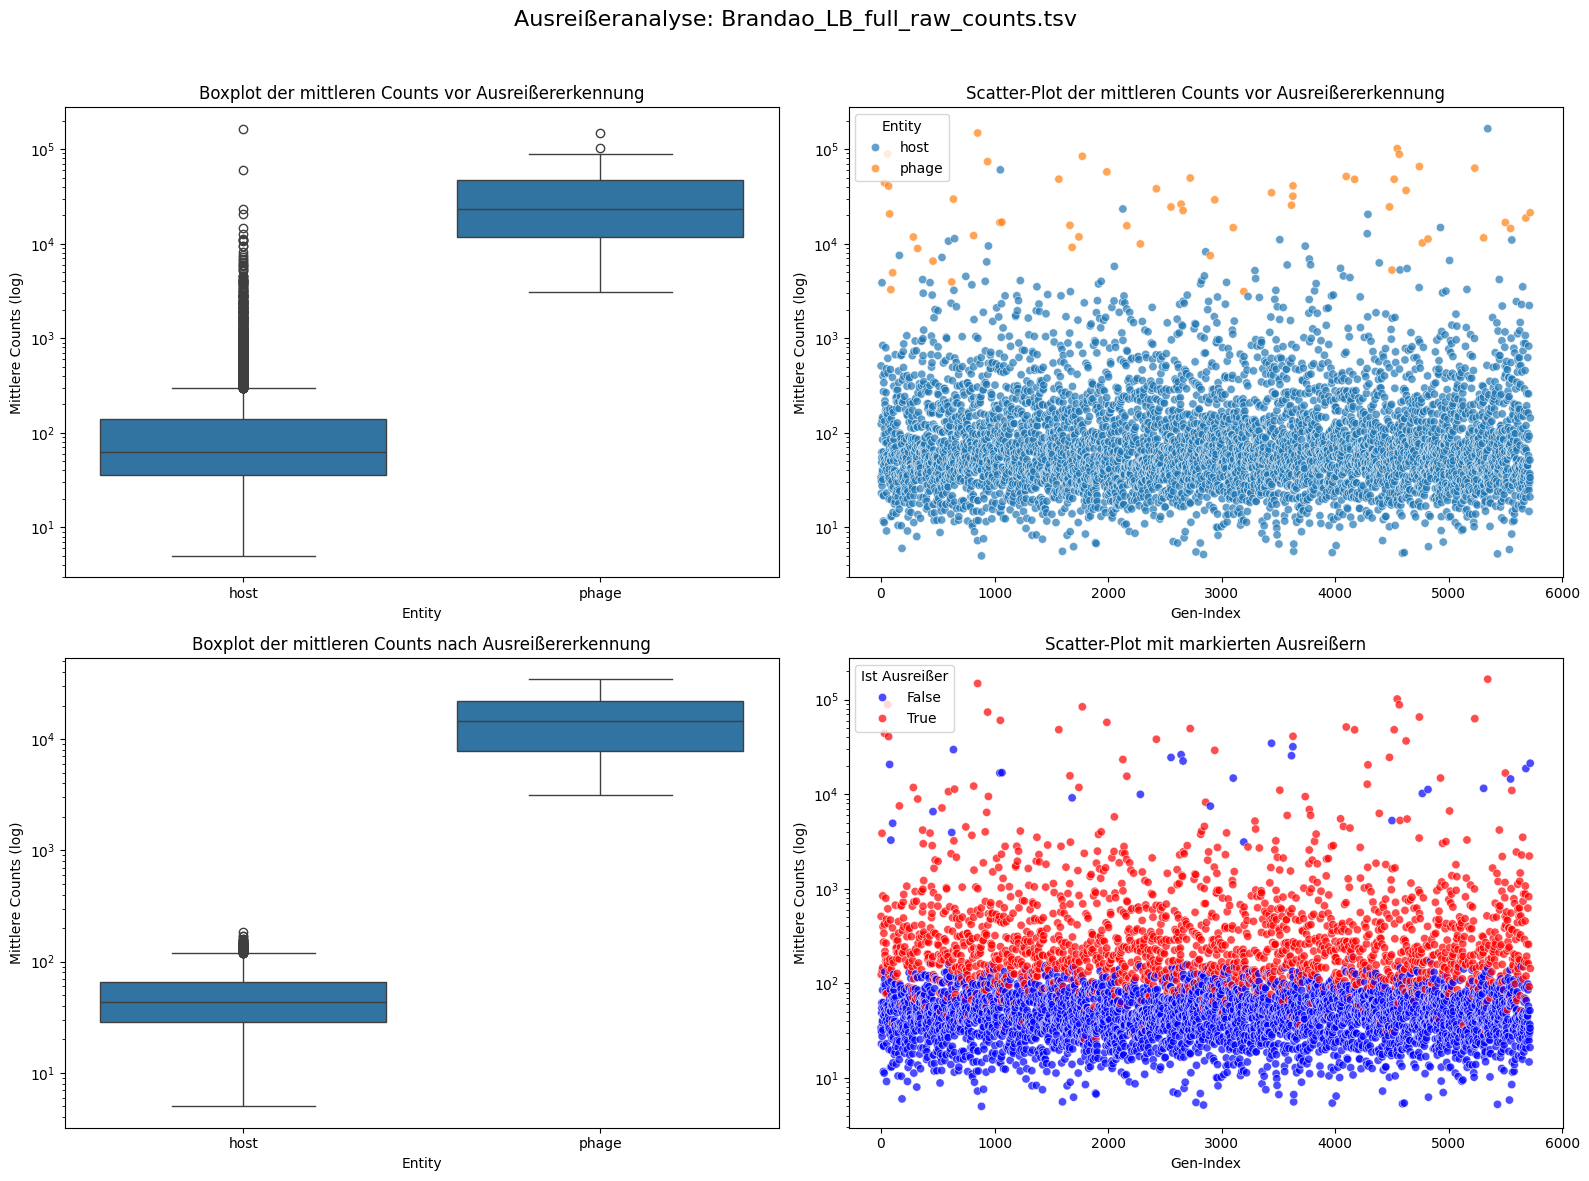

In [87]:
result = mark_outliers(tsv_files[0], method='iqr', threshold=1.5)